# Delay Analysis

In [2]:
import requests as req, os

URL = "https://raw.githubusercontent.com/mit-acl/16_06_Class/main/"
File = ["basic_material.py","control_materials.py"]

if not os.path.isfile(File[0]):
    print('Basic files not found - downloading them')
    for dfile in File:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

print('Basic file found')
%run basic_material.py

from control.matlab import tf, lsim, step, rlocus, feedback, rss, lsim, c2d
from control import bode_plot
    
from control_materials import *

Basic file found
Running Python: 3.12.8
Running Sympy: 1.13.2
Control Package Found
This is a library of useful functions for the control systems in 16.06


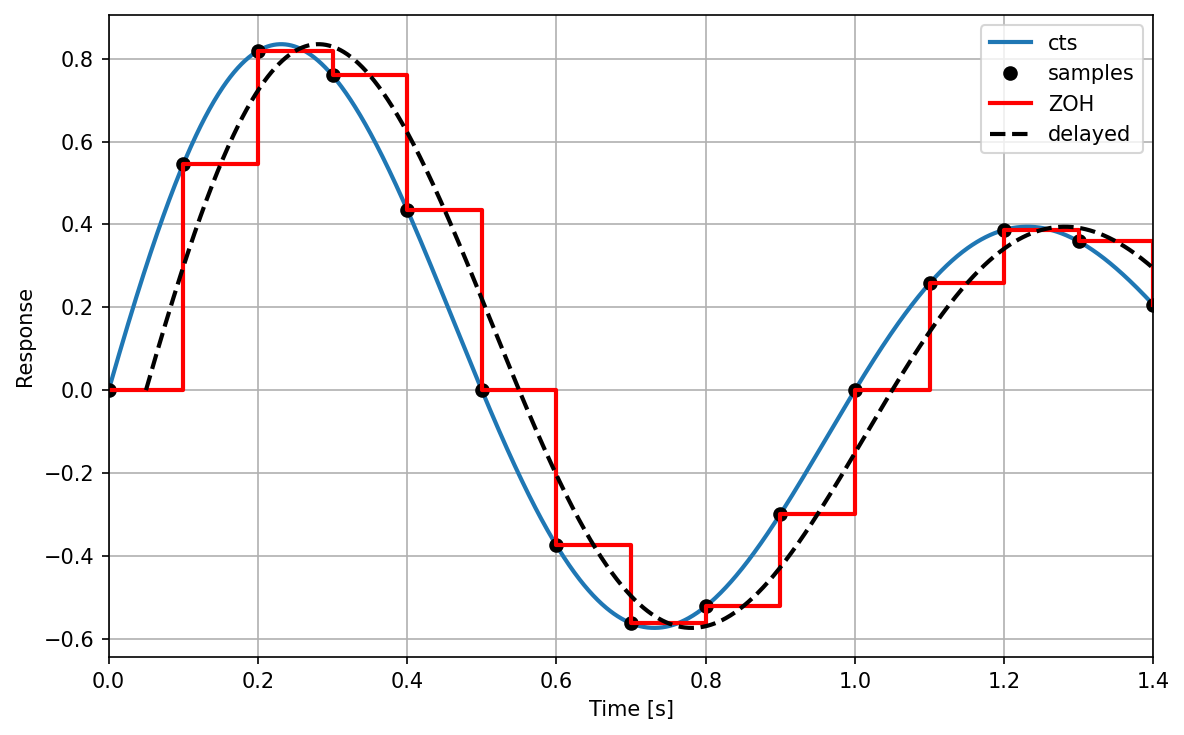

In [3]:
Tf = 1.5 # final time
dt = 1/10  # sampling time
ddt = dt/100  # cts time step

def func(t):
    return np.exp(-0.75*t)*np.sin(2*np.pi*t)

t_disc = np.arange(0,Tf,dt)
t_cts = np.arange(0,Tf,ddt)
y_cts = func(t_cts)
y_disc = func(t_disc)

fig, ax = plt.subplots(1,figsize=(8, 5),dpi=150,sharex = True)
plt.plot(t_cts,y_cts,lw=2,label='cts')
plt.plot(t_disc,y_disc,'ko',label='samples')
plt.step(t_disc,y_disc,lw=2,label='ZOH',where='post',c='r')
plt.plot(t_cts + dt/2,y_cts,'k--',label='delayed')
plt.xlim(0,1.4)
plt.xlabel('Time [s]')
plt.ylabel('Response')
plt.legend()
savefig("./figs/Discrete_1.pdf", dpi=600)
plt.show()


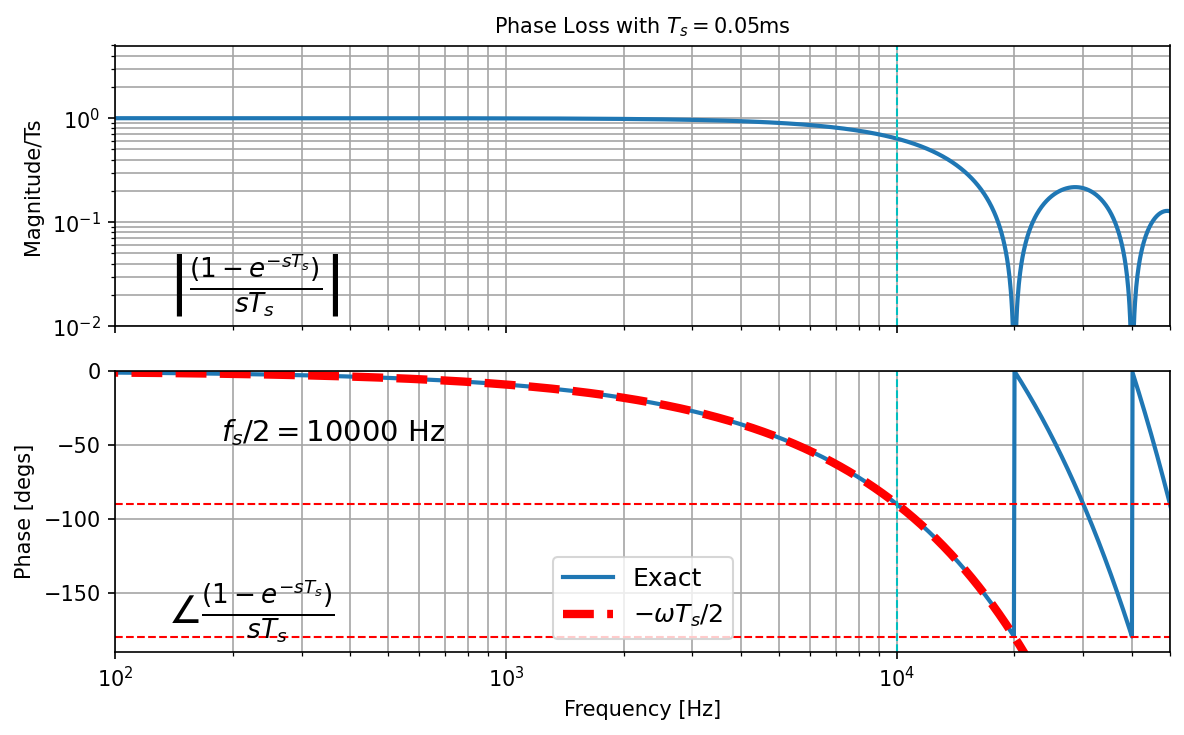

In [4]:
Ts = 50/1e6
f = np.logspace(1,np.log(1/Ts)-1,5000)
w = f*2*np.pi
s = complex(0,1)*w
Gzoh = (1 - np.exp(-s*Ts))/(s*Ts)

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,sharex = True)
ax[0].loglog(f,abs(Gzoh),lw=2,label='cts')
ax[0].set_ylim(1e-2,5)
ax[1].semilogx(f,np.angle(Gzoh)*r2d,lw=2,label='Exact')
ax[1].semilogx(f, (-w*Ts/2)*r2d,'r--',lw=4,label=R'$-\omega T_s/2$')
ax[1].set_ylim(-190,0)
ax[1].set_xlim(100,5e4)
[ax[1].axhline(y = -90*x ,ls='--',c='r',lw=1) for x in range(1,10)]
ax[1].axvline(x = 1/Ts/2 ,ls='--',c='c',lw=1)
ax[0].axvline(x = 1/Ts/2 ,ls='--',c='c',lw=1)
ax[1].legend(loc='lower center', fontsize=12)
ax[0].grid(True, which="both", ls="-",color='0.65')

ax[0].set_title('Phase Loss with $T_s=${:3.2f}ms'.format(Ts*1000))
ax[0].text(.05,.1,r'$\left|\frac{(1 - e^{-sT_s})}{sT_s}\right|$',fontsize=18, transform=ax[0].transAxes)
ax[1].text(0.05, 0.1, r'$\angle \frac{(1 - e^{-sT_s})}{sT_s}$', fontsize=18, transform=ax[1].transAxes)
ax[1].text(0.1, 0.75, r'$f_s/2 = ${:3.0f} Hz'.format(1/Ts/2), fontsize=14, transform=ax[1].transAxes)

ax[0].set_ylabel('Magnitude/Ts')
ax[1].set_ylabel('Phase [degs]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which="both", ls="-",color='0.65')
savefig("./figs/Discrete_2.pdf", dpi=600)
plt.show()

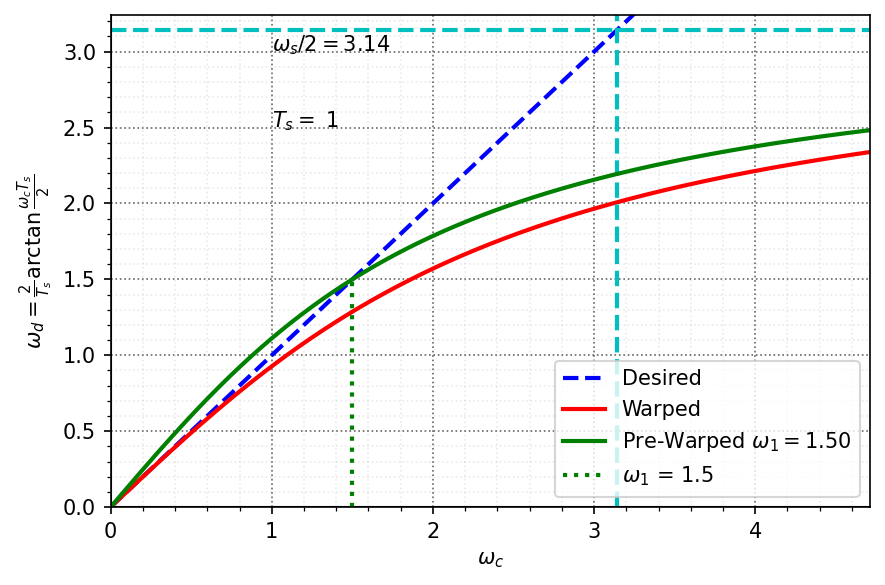

In [30]:
j = complex(0,1)
w = np.linspace(0,1.2*np.pi,500)
Ts = 1
ws = 2*np.pi/Ts
s = j*w
z = np.exp(s*Ts)

wc_w = np.imag(2/Ts*(z-1)/(z+1))
w1 = 1.5
wc_pw = np.imag(w1/np.tan(w1*Ts/2)*(z-1)/(z+1))

fig, ax = plt.subplots(1,figsize=(6, 4),dpi=150,sharex = True)
ax.plot(w,w,'b--',lw=2,label='Desired')
ax.plot(wc_w[:-100],w[:-100],'r-',lw=2,label='Warped')
ax.axvline(x=ws/2,c='c',ls='--')
ax.axhline(y=ws/2,c='c',ls='--')
ax.text(1,2.5,r'$T_s=${:2.0f}'.format(Ts))
ax.text(1,3,r'$\omega_s/2=${:3.2f}'.format(ws/2))
plt.xlim(0,1.5*np.pi)
plt.ylim(0,np.pi+0.1)
plt.xlabel(r'$\omega_c$')
plt.ylabel(r'$\omega_d = \frac{2}{T_s} \arctan \frac{\omega_c T_s}{2}$')
plt.legend()
nicegrid(ax)
savefig("./figs/Discrete_3.pdf", dpi=600)
ax.plot(wc_pw[:-100],w[:-100],'g-',lw=2,label='Pre-Warped $\omega_1 ={:3.2f}$'.format(w1))
ax.axvline(x=w1,ymax=w1/(np.pi+0.1),c='g',ls=':', label=fr'$\omega_1$ = {w1}')
plt.legend()
savefig("./figs/Discrete_3a.pdf", dpi=600)
plt.show()

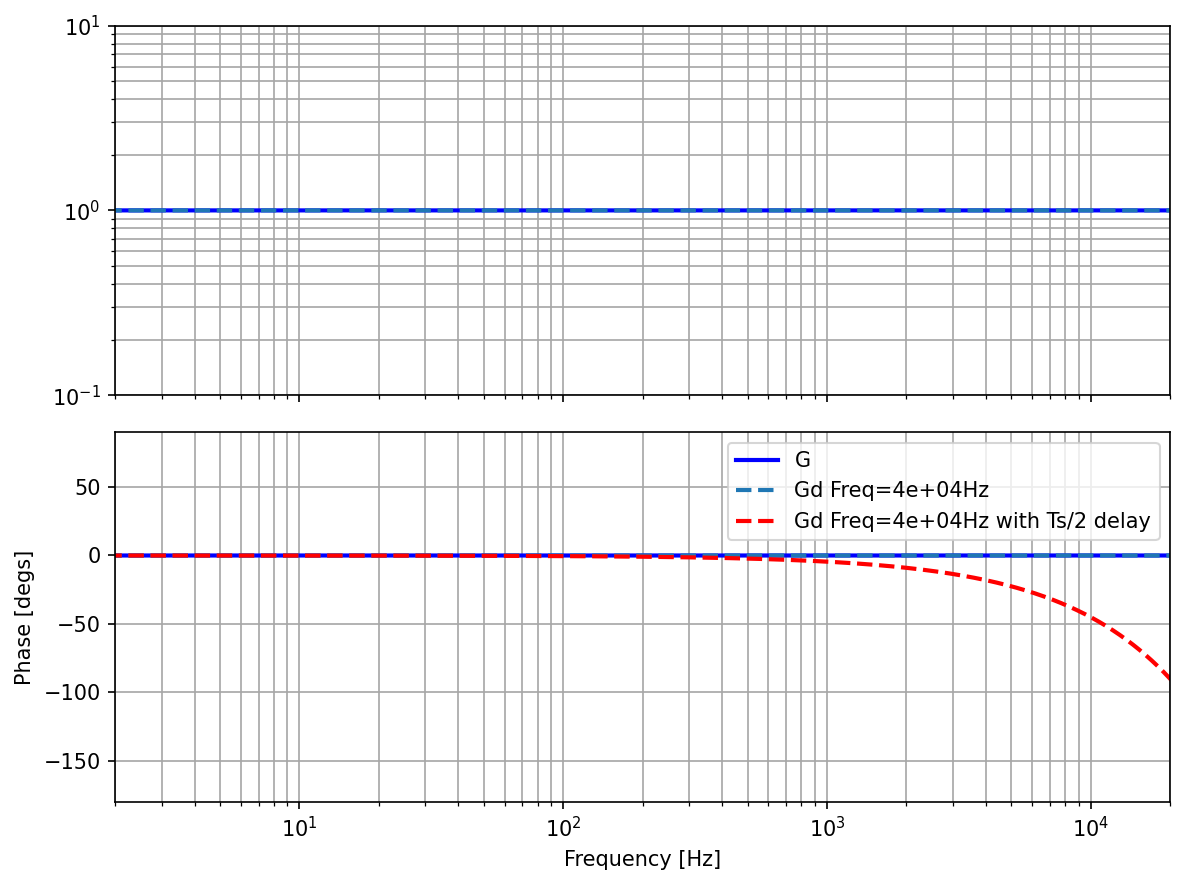

In [6]:
j = complex(0,1)
f = logspace(.1,5,3000) # hz
w = 2*np.pi*f

Ts_set = [25]/np.array([1e6])

if 0:
    fc = 319
    wc = fc*2*np.pi
    z = wc/np.sqrt(10)
    p = 10*z
else:
    z = 100*2*np.pi
    p = 1000*2*np.pi
sysc = tf([1, z], [1, p])
sysc = tf([1], [1]) 
Gf = sysc(j*w);

fig, ax = plt.subplots(2,1,figsize=(8, 6),dpi=150,sharex = True)
ax[0].loglog(f,np.abs(Gf),'b-',label='G')
ax[1].semilogx(f,np.angle(Gf)*r2d,'b-',label='G')

for Ts in Ts_set:
    sysd = c2d(sysc, Ts, method='bilinear')
    [Gmd,Gpd,Gwd] = bode_plot(sysd,plot=False,omega=w)
    ax[0].loglog(Gwd/2/np.pi,Gmd,'--',label='Gd')
    ax[1].semilogx(Gwd/2/np.pi,pshift(Gpd)*r2d,'--',label='Gd Freq={:3.2g}Hz'.format(1/Ts))
    ax[1].semilogx(Gwd/2/np.pi,pshift(Gpd)*r2d-Gwd*Ts/2.0*r2d,'r--',label='Gd Freq={:3.2g}Hz with Ts/2 delay'.format(1/Ts))

ax[1].legend()
ax[1].set_xlim([2,20000])
ax[0].set_ylim([.1,10])
ax[1].set_ylim([-180,90])
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Phase [degs]")
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')

plt.legend()
plt.show()

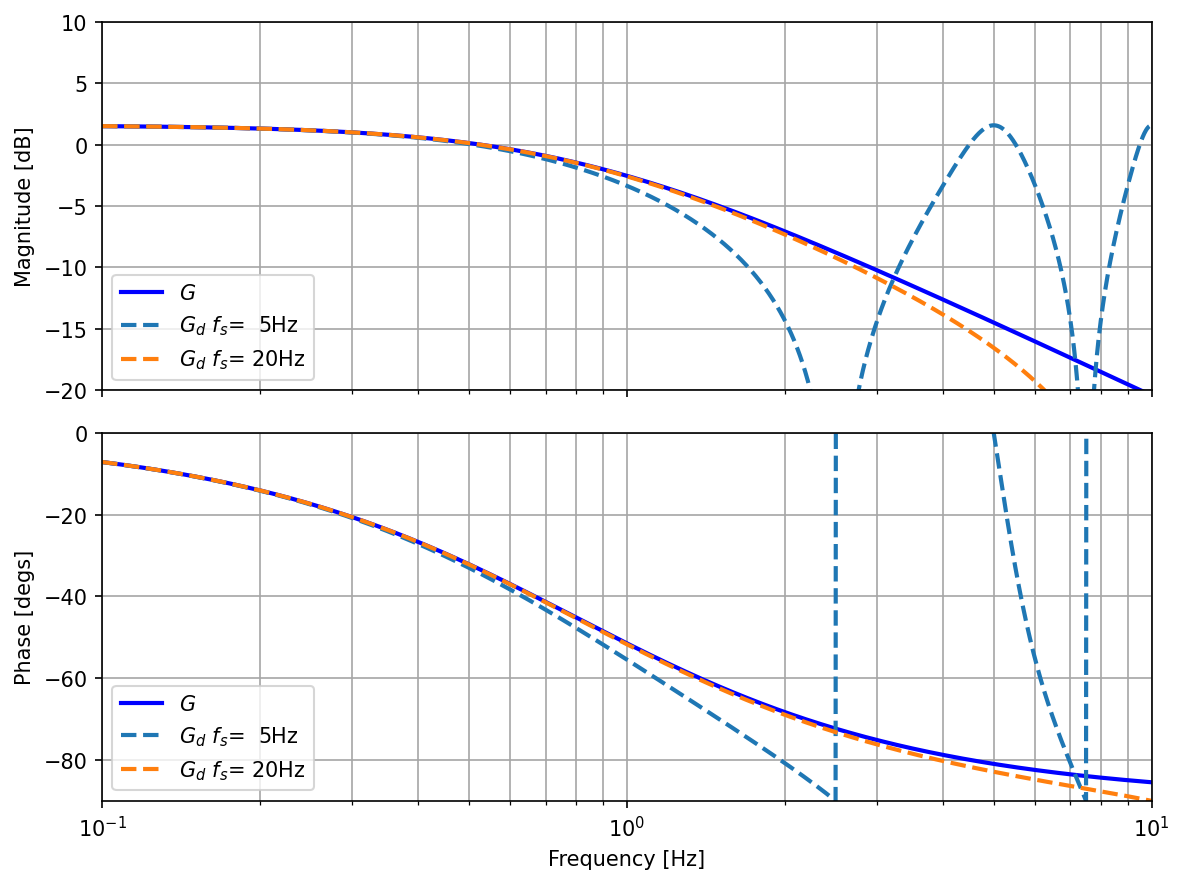

In [47]:
from control.matlab import rss, lsim, c2d

f = logspace(-1,1,2000)
w = 2*np.pi*f
Ts_set = (.2,.05)
j = complex(0,1)

sysc = tf([6], [1, 5])
Gf = sysc(j*w)
wc = find_wc(w, Gf)

fig, ax = plt.subplots(2,1,figsize=(8, 6),dpi=150,sharex = True)
ax[0].semilogx(f,20*np.log10(np.abs(Gf)),'b-',label=r"$G$")
ax[1].semilogx(f,np.angle(Gf)*r2d,'b-',label=r"$G$")

for Ts in Ts_set:
    sysd = c2d(sysc, Ts, method='bilinear')
    [Gmd,Gpd,Gwd] = bode_plot(sysd,plot=False,omega=w)
    ax[0].semilogx(f,20*np.log10(Gmd),'--',label=r"$G_d$ $f_s$={:3.2g}Hz".format(1/Ts))
    ax[1].semilogx(f,pshift(Gpd)*r2d,'--',label=r"$G_d$ $f_s$={:3.2g}Hz".format(1/Ts))

ax[0].set_ylim([-20,10])
ax[0].legend()
ax[1].legend()
ax[1].set_xlim([.1,10])
ax[1].set_ylim([-90,0])
ax[1].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Magnitude [dB]")
ax[1].set_ylabel("Phase [degs]")
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
plt.legend()
plt.show()

In [8]:
import time, csv, os, requests
plt.rcParams["figure.figsize"] = (8,5)

# make sure the data is available to plot
data_file = ["data/lead_at_30khz.csv"]
if not np.min([os.path.isfile(data_file[x]) for x in np.arange(len(data_file))]):
    for dfile in data_file:
        if not os.path.isfile(dfile):
            print("Downloading "+dfile)
            res = req.get(URL+dfile)
            file = open(dfile, 'w')
            file.write(res.text)
            file.close()

data = np.genfromtxt(data_file[0], delimiter=',')


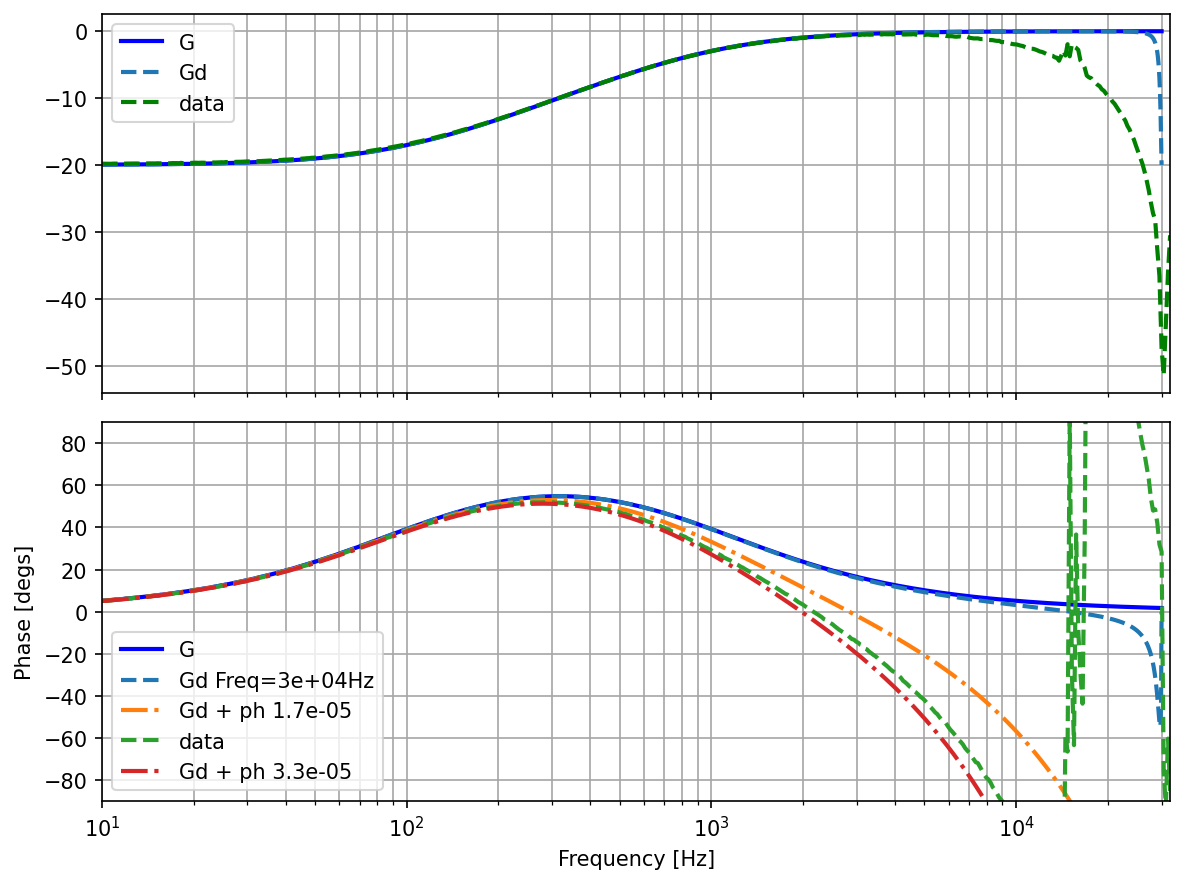

In [9]:
w = logspace(1,np.log10(30e3),2000)*2*np.pi
Ts_set = [1/30e3]

sysc = tf([1, 100*2*np.pi], [1, 999*2*np.pi])
Gf = sysc(j*w);

fig, ax = plt.subplots(2,1,figsize=(8, 6),dpi=150,sharex = True)
ax[0].semilogx(w/2/np.pi,20*np.log10(np.abs(Gf)),'b-',label='G')
ax[1].semilogx(w/2/np.pi,np.angle(Gf)*r2d,'b-',label='G')

for Ts in Ts_set:
    sysd = c2d(sysc, Ts, method='bilinear')
    [Gmd,Gpd,Gwd] = bode_plot(sysd,plot=False,omega=w)
    ax[0].semilogx(Gwd/2/np.pi,20*np.log10(Gmd),'--',label='Gd')
    ax[0].semilogx(data[:,0],data[:,1],'g--',label='data')
    ax[1].semilogx(Gwd/2/np.pi,pshift(Gpd)*r2d,'--',label='Gd Freq={:3.2g}Hz'.format(1/Ts))
    ax[1].semilogx(Gwd/2/np.pi,pshift(Gpd)*r2d + (-w*Ts/2)*r2d,'-.',label='Gd + ph {:3.2g}'.format(Ts/2))
    ax[1].semilogx(data[:,0],data[:,2],'--',label='data')
    ax[1].semilogx(Gwd/2/np.pi,pshift(Gpd)*r2d + (-w*Ts)*r2d,'-.',label='Gd + ph {:3.2}'.format(Ts))

#ax[0].set_ylim([-30,1])
ax[0].legend()
ax[1].legend()
#ax[1].set_xlim([.01,10])
ax[1].set_ylim([-90,90])
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Phase [degs]")
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
plt.legend()
plt.show()

In [10]:
sysd = c2d(sysc, Ts_set[0], method='bilinear')
sysd

TransferFunction(array([   0.915,   -0.896]), array([   1.000,   -0.811]), 3.3333333333333335e-05)

Pole at (Hz) 1167.136
Zero at (Hz) 106.103


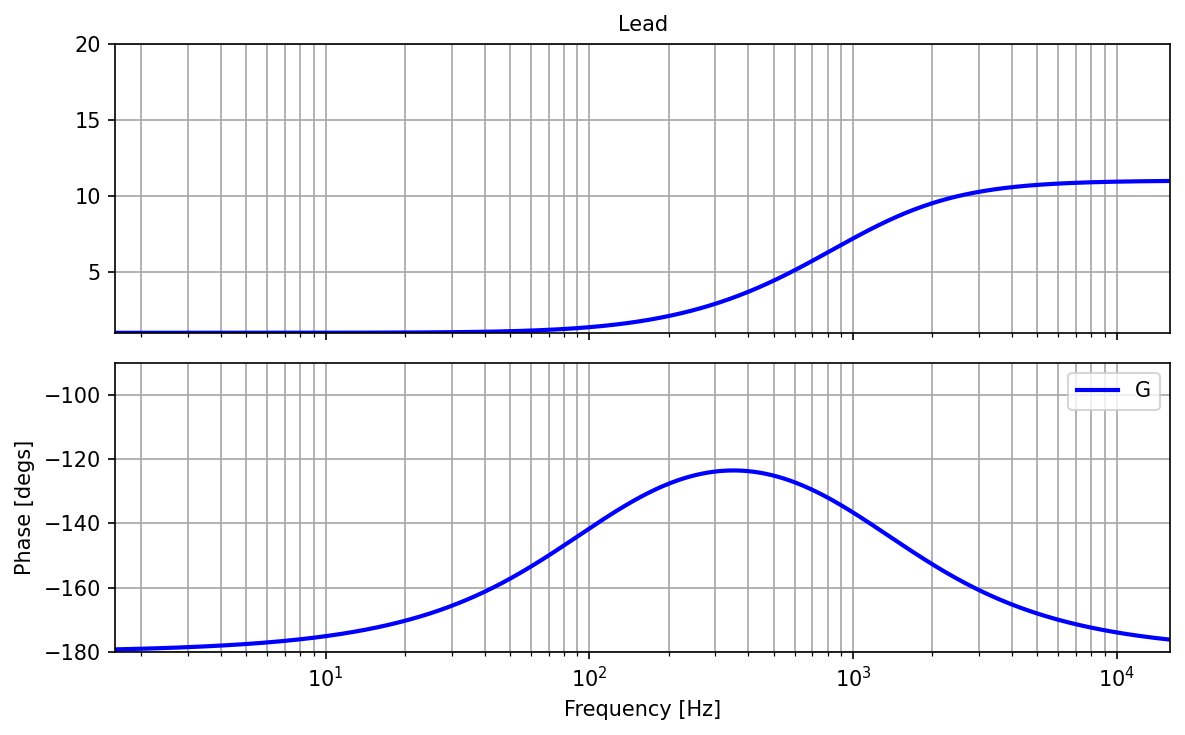

In [11]:
# Analog Lead
R1 = 10e3 # 10K
R2 = 0.1*R1  # 1K
Rf = R1+R2 
C = 0.15e-6 # 154
z = 1/R1/C
p = (R1+R2)/(R1*R2*C)
a = p/z
print("Pole at (Hz) {:6.3f}".format(p/2/np.pi))
print("Zero at (Hz) {:6.3f}".format(z/2/np.pi))

w = logspace(1,5,2000)
sysc = -a*tf([1, z], [1, p])
Gf = sysc(j*w);

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,sharex = True)
ax[0].semilogx(w/2/np.pi,np.abs(Gf),'b-',label='G')
ax[1].semilogx(w/2/np.pi,np.angle(Gf)*r2d,'b-',label='G')
ax[0].set_title('Lead')
ax[0].set_ylim([1,20])
ax[1].legend()
ax[1].set_xlim([min(w/2/np.pi),max(w/2/np.pi)])
ax[1].set_ylim([-180,-90])
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Phase [degs]")
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')

plt.show()

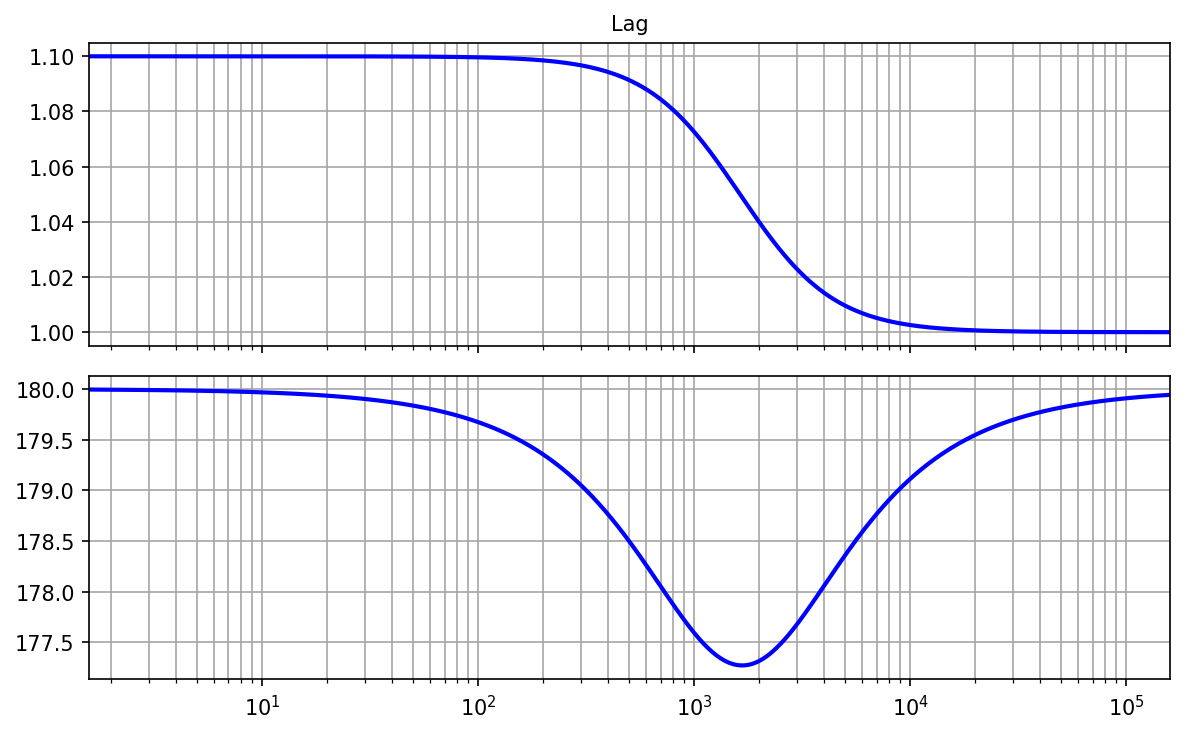

In [12]:
# Analog Lag
R1 = 100e3
R2 = 10*R1
Ri = R2
C = 1e-9
a = R2/Ri
z = (R1+R2)/(R1*R2*C)
p = 1/R1/C

w = logspace(1,6,2000)
sysc = -a*tf([1, z], [1, p])
Gf = sysc(j*w);

fig, ax = plt.subplots(2,1,figsize=(8, 5),dpi=150,sharex = True)
ax[0].semilogx(w/2/np.pi,np.abs(Gf),'b-',label='G')
ax[1].semilogx(w/2/np.pi,np.angle(Gf)*r2d,'b-',label='G')
ax[0].set_title('Lag')
ax[0].grid(True, which="both", ls="-",color='0.65')
ax[1].grid(True, which="both", ls="-",color='0.65')
plt.show()

In [13]:
control.tf2ss(control.c2d(sysc,.1))

StateSpace(array([[  -0.000]]), array([[   1.000]]), array([[  -0.100]]), array([[  -1.000]]), 0.1)

In [14]:
sysc

TransferFunction(array([  -1.000, -11000.000]), array([   1.000,  10000.000]))

In [15]:
sysc.num[0][0][0]

-1.0

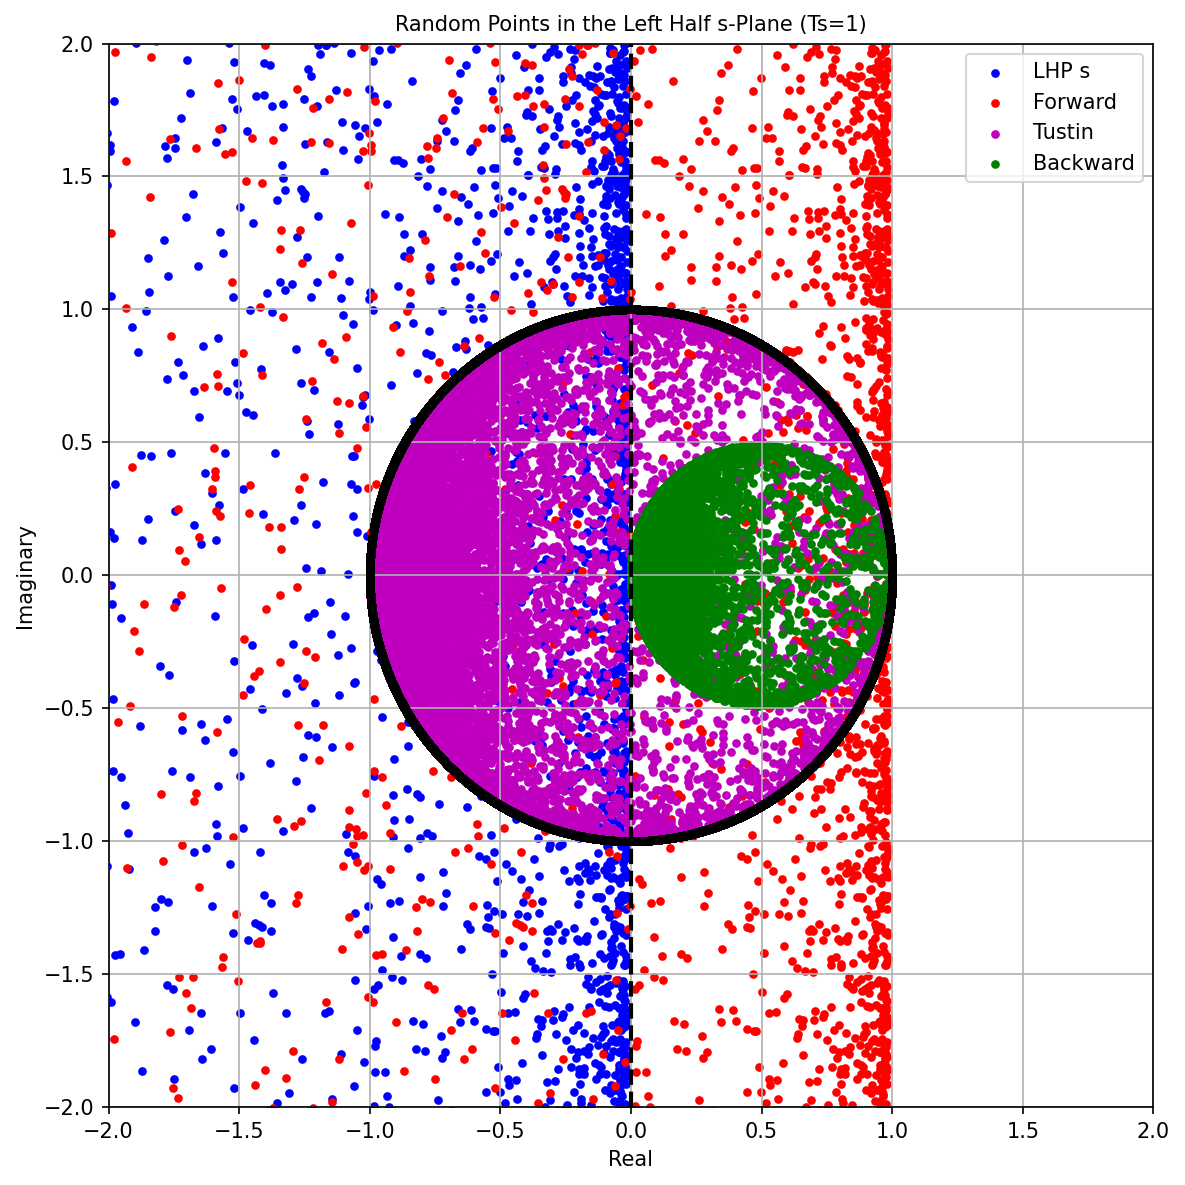

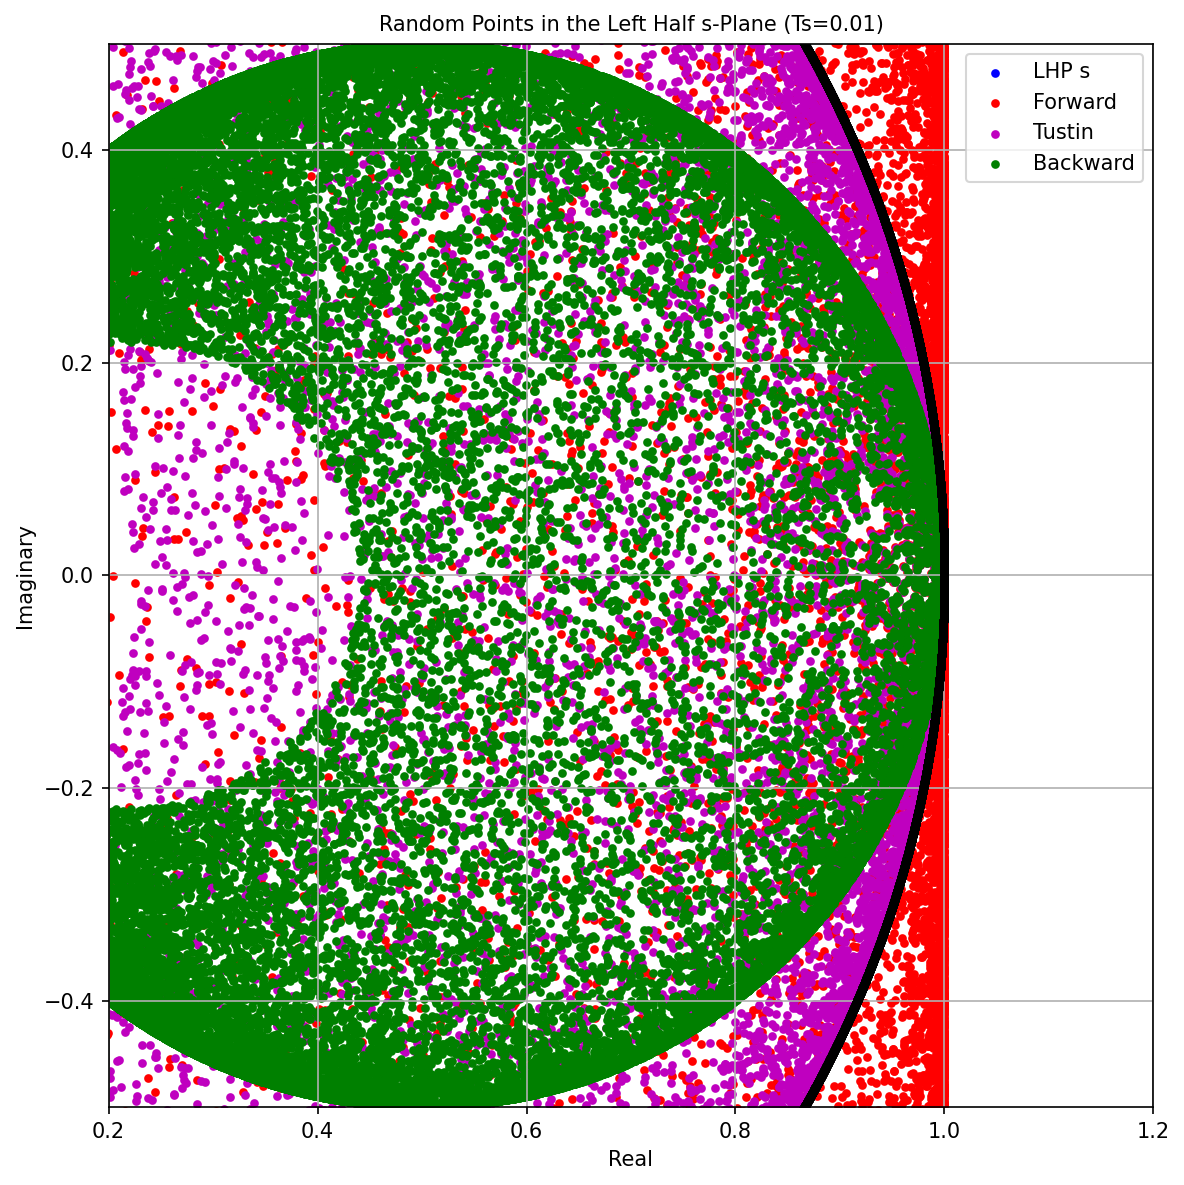

In [103]:
import numpy as np
N = 100000
# Generate random points in the left half s-plane
real_part = -2**(13*np.random.rand(N)-6)  # Negative real part
imaginary_part = (np.random.rand(N) * 2 * np.pi -np.pi)*20  # Imaginary part between -pi and pi
for Ts in [1,.01]:
    s_points = real_part + 1j * imaginary_part/np.sqrt(Ts)
    Zb = 1/(1-s_points*Ts)
    Zf = (1+s_points*Ts)
    ZT = (1+s_points*Ts/2)/(1-s_points*Ts/2)
    z = np.exp(-j*imaginary_part)

    # Plot the points
    plt.figure(figsize=(8, 8))
    plt.scatter(s_points.real, s_points.imag, color='blue', s=10)
    plt.scatter(Zf.real, Zf.imag, color='r', s=10)
    plt.scatter(ZT.real, ZT.imag, color='m', s=10)
    plt.scatter(Zb.real, Zb.imag, color='g', s=10)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.plot(z.real, z.imag, 'k.', lw=2)
    plt.title(f'Random Points in the Left Half s-Plane (Ts={Ts})')
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.legend(('LHP s','Forward','Tustin','Backward'))
    if Ts < 1:
        plt.xlim(.2,1.2)
        plt.ylim(-.5,.5)
    else:
        plt.xlim(-2,2)
        plt.ylim(-2,2)
    plt.grid(True)
    plt.show()